# Analyzing a Solar System Integration
This notebook reproduces Figures 1-3 from the paper "A new paradigm for reproducing and analyzing N-body simulations" by Rein & Tamayo.

We first import REBOUND, ctypes, numpy and matplotlib.

In [ ]:
import rebound
print(rebound.__build__)
import numpy as np
import warnings
from ctypes import cdll, byref
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %matplotlib inline
    import matplotlib.pyplot as plt

The original simulation includes additional forces due to general relativity. These forces must be present when accessing the Simulation Archive. We can either import these forces from a c library or use equiavalent forces implemented in python. The c library is faster but requires you to compile it first (source code and make file are included). If the c library is not available, the following code will use the python version instead.

In [ ]:
try:
    cgr = cdll.LoadLibrary("gr_force.so")
    gr_force = cgr.gr_force
except:
    print("Using fall-back python implementation of GR force. This might be slower than using the C version.")
    def gr_force(sim):
        ps = sim.contents.particles
        source = ps[0]
        prefac1 = 6.*source.m*source.m/1.0130251e+08
        for i in range(1,sim.contents.N):
            p = ps[i]
            dp = p - source
            r2 = dp.x*dp.x + dp.y*dp.y + dp.z*dp.z
            prefac = prefac1/(r2*r2)
            ps[i].ax -= prefac*dp.x
            ps[i].ay -= prefac*dp.y
            ps[i].az -= prefac*dp.z
            ps[0].ax += p.m/source.m*prefac*dp.x
            ps[0].ay += p.m/source.m*prefac*dp.y
            ps[0].az += p.m/source.m*prefac*dp.z
def setup(sim):
    sim.additional_forces=gr_force            

To calculate the energy, we need to calculate the contribution from the GR term in the potential.

In [ ]:
def gr_potential(sim):
    source = sim.particles[0]
    mu = sim.G*source.m
    prefac = 3.*mu*mu/1.0130251e+08
    grpot = 0.
    for i in range(1,sim.N):
        pi = sim.particles[i] - source
        r2 = pi.x*pi.x + pi.y*pi.y + pi.z*pi.z
        grpot -= prefac*sim.particles[i].m/r2
    return grpot

We can now load the binary file into a Simulation Archive object. Note that the setup function sets up the additional GR forces. If no additional forces are present, no setup function is required.

In [4]:
sa = rebound.SimulationArchive("restart_0013.bin",setup=setup)

/Users/rein/git/rebound/rebound/simulationarchive.py:59: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


## The following code reproduces Figure 1

1 loop, best of 1: 1.99 s per loop


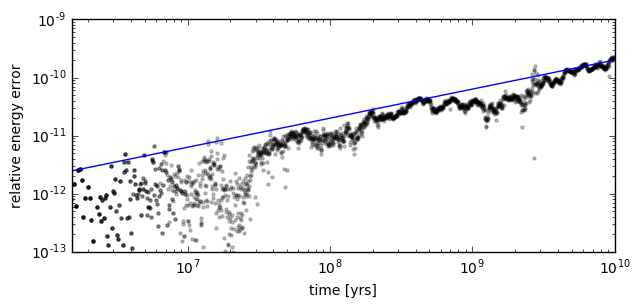

In [5]:
%%timeit -n1 -r1 
fig = plt.figure(figsize=(7, 3)) 
ax = plt.subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-13,1e-9])
sim0 = sa.getSimulation(0.)
e0 = sim0.calculate_energy()+gr_potential(sim0)

if False:
    times = np.logspace(3., 8, 2500)
    data = np.zeros((2,len(times)))
    for j, sim in enumerate(sa.getSimulations(times, mode='close')):
        data[0][j] = sim.t
        data[1][j] = np.abs((e0-sim.calculate_energy()-gr_potential(sim))/e0)    
    ax.scatter(data[0]/(2.*np.pi), data[1],marker=".");
    ax.set_xlim([data[0][0]/(2.*np.pi),sa.tmax/(2.*np.pi)])    

times = np.logspace(7., np.log10(sa.tmax), 2000)
data = np.zeros((2,len(times)))
for j, sim in enumerate(sa.getSimulations(times)):
    data[0][j] = sim.t
    data[1][j] = np.abs((e0-sim.calculate_energy()-gr_potential(sim))/e0)
    
ax.set_xlim([data[0][0]/(2.*np.pi),sa.tmax/(2.*np.pi)])        
ax.set_xlabel("time [yrs]")
ax.set_ylabel("relative energy error")
ax.scatter(data[0]/(2.*np.pi), data[1],marker=".",color="black",alpha=0.24);
ax.plot([1e5,1e10],2e-10*np.sqrt([1e5,1e10])/1e5);
plt.savefig("f_energy.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

## The following code reproduces Figure 2

In [6]:
def moving_average(a, n=3) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

1 loop, best of 1: 2.31 s per loop


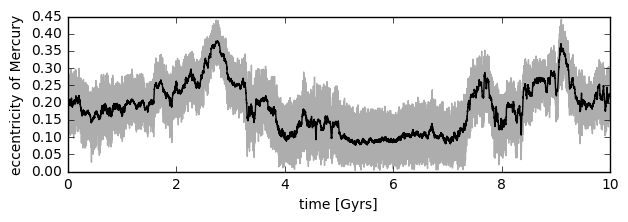

In [7]:
%%timeit -n1 -r1 
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
times = np.linspace(sa.tmin, sa.tmax, 20000)
data = np.zeros((2,len(times)))
le =0
for i, sim in enumerate(sa.getSimulations(times)):
    data[0][i] = sim.t/2/np.pi/1e9
    data[1][i] = sim.particles[1].e
ax.set_xlim([0,data[0][-1]])            
n=30
ax.set_xlabel("time [Gyrs]")
ax.set_ylabel("eccentricity of Mercury")
ax.plot(data[0], data[1], color="black",alpha=0.32);
ax.plot(data[0][n//2:-n//2+1], moving_average(data[1],n=n),color="black");
plt.savefig("f_eccentricity.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

## The following code reproduces Figure 3
This is done in parallel. We first load the Simulation Archive on each of our threads. This ensures that each thread has its own copy of the object.

In [ ]:
from multiprocessing import Pool
def thread_init(*rest):
    global sat
    cgr = cdll.LoadLibrary("gr_force.so")
    gr_force = cgr.gr_force
    def setup(sim):
        sim.additional_forces=gr_force            
    sat = rebound.SimulationArchive("restart_0013.bin",setup=setup)
pool = Pool()#initializer=thread_init) 

The following `analyze` function is then executed for different `t` on those threads.

In [ ]:
def analyze(t):
    sim = sat.getSimulation(t,mode="close")
    return [sim.t/2/np.pi,sim.particles[3].e]

In [ ]:
times = np.linspace(0.1, 801e3*2.*np.pi, 1000)
res = np.array(pool.map(analyze,times))
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
ax.set_xlim([0,res[-1][0]])            
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity of Earth")
ax.plot(res[:,0], res[:,1], color="black");
plt.savefig("f_eccentricity_earth.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

We can generate the second panel of Figure 4 in the same way. 

In [ ]:
times = np.linspace(5e9*2*np.pi+0., 5e9*2*np.pi+801e3*2.*np.pi, 1000)
res = np.array(pool.map(analyze,times))
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
ax.set_xlim([res[1][0],res[-1][0]])            
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity of Earth")
ax.plot(res[:,0], res[:,1], color="black");
plt.savefig("f_eccentricity_earth5.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
pool.close()